<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>I - Introduction</h2>

<p>
Ce notebook s’inscrit dans une démarche de <b>comparaison méthodique des
stratégies de prétraitement textuel</b> pour un modèle de classification
multi-classes basé sur un Transformer. L’objectif n’est pas uniquement
d’identifier la stratégie conduisant au meilleur score, mais également de
<b>comprendre l’impact réel des choix de prétraitement</b> sur les performances
et la dynamique d’apprentissage du modèle.
</p>

<p>
L’ensemble des expériences repose sur un cadre strictement contrôlé : le modèle
de base (<i>almanach/camembert-base</i>), les hyperparamètres d’entraînement et les
procédures d’optimisation sont identiques pour toutes les expérimentations. La
seule variable étudiée est la <b>stratégie de prétraitement appliquée aux textes</b>
(titres et descriptions de produits), garantissant ainsi une comparaison
équitable et interprétable.
</p>

<p>
Les stratégies évaluées couvrent un spectre progressif allant du <b>texte brut</b>
à des approches plus élaborées intégrant un nettoyage textuel et différentes
formes d’<b>abstraction numérique</b>, notamment une normalisation ciblée des
grandeurs physiques (longueur, surface, volume, poids). Cette progression permet
d’analyser finement l’apport de chaque niveau de transformation.
</p>

<p>
Les métriques d’entraînement et de validation sont systématiquement enregistrées
via <b>Weights & Biases (W&amp;B)</b>, qui constitue la source de référence pour
l’ensemble des résultats expérimentaux. Ce notebook ne vise pas à relancer les
entraînements, mais à <b>agréger, visualiser et interpréter</b> les résultats issus
de ces logs, selon deux axes complémentaires : la comparaison des performances
finales et l’étude de la dynamique d’apprentissage au fil des époques.
</p>

</div>


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>II - Protocole expérimental</h2>

<p>
Cette section présente le cadre expérimental retenu pour comparer différentes
stratégies de prétraitement du texte dans un contexte de classification à l’aide
d’un modèle Transformer pré-entraîné. L’objectif est d’évaluer l’impact de ces
transformations <b>à architecture et hyperparamètres constants</b>.
</p>

<p>
Trois familles de prétraitement sont étudiées :
</p>

<ul>
  <li>
    <b>Texte brut</b>, utilisé comme référence, sans modification du contenu
    lexical.
  </li>
  <li>
    <b>Nettoyage léger (<i>TextCleaner</i>)</b>, limité aux opérations non
    destructives (<code>fix_encoding</code>, <code>unescape_html</code>,
    <code>normalize_unicode</code>), afin de corriger les artefacts techniques
    sans altérer la structure sémantique du texte.
  </li>
  <li>
    <b>Tokenisation numérique (<i>NumericTokens</i>)</b>, selon différentes
    stratégies, visant à remplacer certaines expressions quantitatives par des
    tokens sémantiques discrets, depuis une version <i>light</i> ciblée jusqu’à
    des variantes plus étendues.
  </li>
</ul>

<p>
Toutes les expériences reposent sur le modèle
<b>CamemBERT-base</b> (<code>almanach/camembert-base</code>). Les textes sont
tronqués ou paddés à une longueur maximale de <b>384 tokens</b>, produisant en
sortie une séquence d’embeddings de dimension
<b>384 × 768</b>. La représentation globale du texte est obtenue par un
<b>pooling moyen</b> sur l’ensemble des tokens, avant passage dans un
classifieur composé d’une couche cachée de <b>512 unités</b>.
</p>

<p>
Les hyperparamètres d’entraînement sont maintenus identiques pour l’ensemble des
runs (learning rate = <code>2e-5</code>, batch size = <code>64</code>, scheduler
cosinus avec warmup, <code>8</code> époques), afin de garantir une comparaison
équitable entre les stratégies de prétraitement.
</p>

</div>


<div style="background:#fff3cd; padding:12px; border-left:6px solid #ffdd57; border-radius:4px">
En raison du caractère itératif des expérimentations, le notebook d’entraînement peut ne pas afficher l’ensemble des sorties associées à chaque run. L’intégralité des expériences demeure néanmoins traçable et reproductible via les logs W&B correspondants.
</div>



In [2]:
import sys
sys.path.insert(0, '../src')
from data import load_data
from features.text import NumericTokensTransformer, TextCleaner, MergeTextTransformer
from models.text import TextClassifier, TextDataset
from models import Trainer, EarlyStopping

import torch
from torch.utils.data import DataLoader 
from torch.optim import AdamW
from transformers import AutoTokenizer, get_cosine_schedule_with_warmup

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import wandb

In [ ]:
# config
MODEL_NAME = "almanach/camembert-base"
MAX_LENGTH = 384
BATCH_SIZE = 64
EPOCHS = 8
MLP_DIM = 512
LR = 2e-5
WARMUP_RATIO = 0.1

# transformation testée
transformers = {
    "texte brute" : MergeTextTransformer(sep="[SEP]"),
    "cleaner" : Pipeline([
        ('cleaner', TextCleaner(remove_html_tags=False)),
        ('merger', MergeTextTransformer(sep="[SEP]"))
    ]),
    "numtok ligth" : NumericTokensTransformer(strategy='light'),
    "numtok full" : NumericTokensTransformer(strategy='full'),
    "cleaner + numtok ligth" : Pipeline([
        ('cleaner', TextCleaner(remove_html_tags=False)),
        ('numtok', NumericTokensTransformer(strategy='light'))
    ]),
    "numtok phys" : NumericTokensTransformer(strategy='phys'),
}

# permet de récupérer les extra tokens des pipelines
def get_extra_tokens_from_transformer(transformer):
    """
    Récupère les extra tokens d'un transformer sklearn ou d'un Pipeline.
    """
    # Cas simple : le transformer expose directement get_extra_tokens
    if hasattr(transformer, "get_extra_tokens"):
        return transformer.get_extra_tokens()

    # Cas Pipeline sklearn
    if isinstance(transformer, Pipeline):
        for _, step in reversed(transformer.steps):
            if hasattr(step, "get_extra_tokens"):
                return step.get_extra_tokens()

    return []

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, X_val, X_test, y_train, y_val, y_test = load_data(splitted=True).values()

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.tolist())
y_val = encoder.transform(y_val.tolist())


for name, transformer in transformers.items():

    # 1️⃣ Texte
    X_train_t = transformer.fit_transform(X_train)
    X_val_t = transformer.transform(X_val)

    # 2️⃣ Tokens
    extra_tokens = get_extra_tokens_from_transformer(transformer)

    # 3️⃣ Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
    if extra_tokens:
        tokenizer.add_special_tokens({"additional_special_tokens": extra_tokens})

    # 4️⃣ Dataset
    train_dataset = TextDataset(tokenizer, X_train_t, y_train, max_length=MAX_LENGTH)
    val_dataset = TextDataset(tokenizer, X_val_t, y_val, max_length=MAX_LENGTH)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 5️⃣ Modèle
    model = TextClassifier(
        model_name=MODEL_NAME,
        num_labels=27,
        mlp_dim=MLP_DIM,
        pooling="mean"
    )
    model.backbone.resize_token_embeddings(len(tokenizer)+1)
    model.to(device)

    # 6️⃣ Optimisation
    optimizer = AdamW(model.parameters(), lr=LR)
    num_training_steps = len(train_loader) * EPOCHS

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(WARMUP_RATIO * num_training_steps),
        num_training_steps=num_training_steps
    )

    # 7️⃣ W&B
    wandb.init(
        project="ds_rakuten",
        name=f"camembert_{name}",
        reinit=True,
    )

    wandb.config.update({
        "model": MODEL_NAME,
        "max_length": MAX_LENGTH,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "mlp_dim": MLP_DIM,
        "scheduler": "cosine_with_warmup",
        "warmup_ratio": WARMUP_RATIO,
        "transformation": name,
        "n_extra_tokens": len(extra_tokens),
        "vocab_size": len(tokenizer),
    })

    trainer = Trainer(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        scheduler_type="step",
    )

    early_stopping = EarlyStopping(patience=3, mode="max")

    print(f"\n===== Entraînement : {name} =====")

    # 8️⃣ Training loop
    for epoch in range(1, EPOCHS + 1):
        train_metrics, train_loss = trainer.train_epoch(train_loader, epoch)
        val_metrics, val_loss = trainer.eval_epoch(val_loader, epoch)

        wandb.log({
            "epoch": epoch,
            "train/loss": train_loss,
            "train/accuracy": train_metrics["accuracy"],
            "train/f1": train_metrics["f1_weighted"],
            "val/loss": val_loss,
            "val/accuracy": val_metrics["accuracy"],
            "val/f1": val_metrics["f1_weighted"],
            **{
                f"lr/group_{i}": g["lr"]
                for i, g in enumerate(optimizer.param_groups)
            }
        })

        if early_stopping.step(val_metrics["f1_weighted"]):
            print("Early stopping déclenché")
            break

    wandb.finish()

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>III - Analyse des résultats</h2>

<p>
Les résultats des différentes expérimentations ont été <b>préalablement extraits
et consolidés sous forme de fichiers CSV</b>. Ces fichiers contiennent les
métriques d’entraînement et de validation nécessaires à la comparaison des
stratégies de prétraitement.
</p>

<p>
La suite de ce notebook repose exclusivement sur l’analyse de ces données afin de se concentrer sur
l’interprétation des performances et de la dynamique d’apprentissage.
</p>

</div>


In [3]:
history_df = pd.read_csv('results/embedding_preprocess/history.csv')
history_df.head(3)

,epoch,train/loss,train/f1,val/loss,val/f1,name,strategy
0,1,1.555173,0.571871,0.591768,0.825839,camembert_texte brute,texte brute
1,2,0.511187,0.844998,0.449098,0.858844,camembert_texte brute,texte brute
2,3,0.371084,0.885231,0.391720,0.881255,camembert_texte brute,texte brute


In [42]:
# 1️⃣ Pour chaque modèle, garder la ligne où val/f1 est maximal
best_f1_df = (
    history_df
    .sort_values("val/f1", ascending=False)
    .groupby("name", as_index=False)
    .first()
)

# 2️⃣ Sélectionner et renommer les colonnes utiles
best_f1_df = best_f1_df[[
    "strategy",
    "epoch",
    "val/f1",
    "val/loss",
    "train/f1",
    "train/loss",
]]

print("-"*25 + " meilleurs f1 de validation par stratégie "+"-"*25)

display(best_f1_df.sort_values("val/f1", ascending=False).round(4))


------------------------- meilleurs f1 de validation par stratégie -------------------------


,strategy,epoch,val/f1,val/loss,train/f1,train/loss
5,texte brute,8,0.8961,0.3786,0.9595,0.1359
3,numtok ligth,8,0.8958,0.3730,0.9590,0.1371
4,numtok phys,8,0.8944,0.3772,0.9584,0.1375
0,cleaner,7,0.8944,0.3747,0.9533,0.1489
1,cleaner + numtok ligth,8,0.8929,0.3786,0.9580,0.1392
2,numtok full,7,0.8913,0.3843,0.9488,0.1622


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<p>
Les résultats obtenus montrent que les différentes stratégies de prétraitement
ont un impact <b>mesuré mais significatif</b> sur les performances du modèle. Le
<b>texte brut</b> constitue une référence solide et atteint le meilleur score F1
de validation, illustrant la capacité du modèle Transformer à exploiter
directement les signaux lexicaux et contextuels présents dans les données.
</p>

<p>
Les stratégies de <b>tokenisation numérique légère</b>, en particulier
<i>numtok light</i> et <i>numtok phys</i>, obtiennent des performances très proches
du texte brut, avec une <b>loss de validation plus faible</b>. Cela suggère qu’une
abstraction numérique ciblée peut améliorer la qualité des probabilités prédites
sans dégrader la capacité de discrimination du modèle.
</p>

<p>
À l’inverse, les approches combinant nettoyage textuel et normalisation
numérique, ainsi que la stratégie <i>numtok full</i>, montrent une baisse plus nette
des performances. Ces résultats indiquent que des <b>prétraitements trop
agressifs</b> tendent à supprimer ou homogénéiser des signaux utiles, déjà bien
pris en charge par le pré-entraînement du Transformer.
</p>

<p>
Dans l’ensemble, ces observations confirment qu’avec des modèles pré-entraînés,
une approche de prétraitement <b>conservatrice et ciblée</b> est préférable à une
normalisation extensive, afin de préserver la richesse informative du texte.
</p>

<p>
Au regard de ces résultats globaux, deux stratégies se distinguent par leurs
performances et leur comportement complémentaire : le <b>texte brut</b> et la
<b>tokenisation numérique légère (<i>numtok light</i>)</b>. Nous proposons donc
d’analyser plus en détail ces deux approches, en étudiant leur dynamique
d’apprentissage et l’évolution de leurs métriques au fil des époques.
</p>

</div>

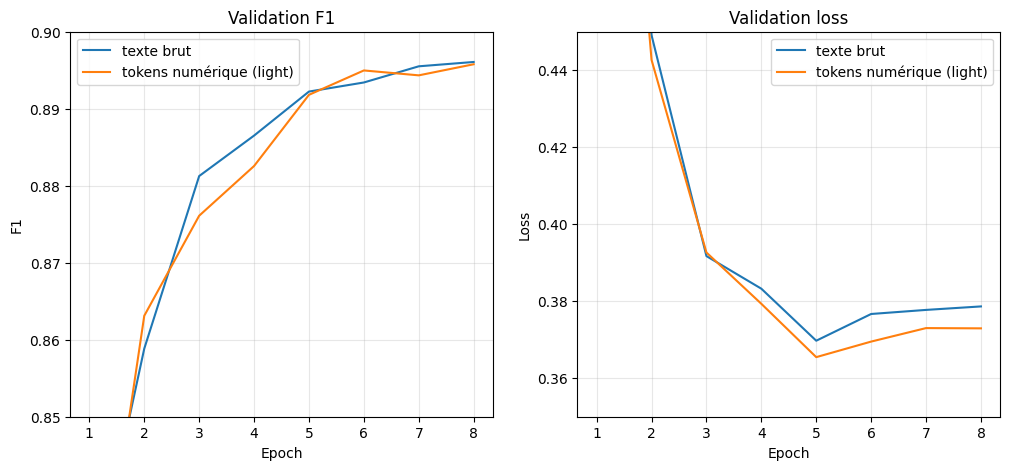

In [32]:
texte_brut = history_df[history_df['strategy'] == "texte brute"]
numtok_ligth = history_df[history_df['strategy'] == "numtok ligth"]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(texte_brut['epoch'], texte_brut['val/f1'], label='texte brut')
ax1.plot(numtok_ligth['epoch'], numtok_ligth['val/f1'], label='tokens numérique (light)')
ax1.set_title("Validation F1")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("F1")
ax1.legend()
ax1.set_ylim(0.85, 0.9)

ax2.plot(texte_brut['epoch'], texte_brut['val/loss'], label='texte brut')
ax2.plot(numtok_ligth['epoch'], numtok_ligth['val/loss'], label='tokens numérique (light)')
ax2.set_title("Validation loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.set_ylim(0.35, 0.45)
ax1.grid(alpha=0.3)
ax2.grid(alpha=0.3)
plt.show()

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>Analyse ciblée : texte brut vs numtok light</h3>

<p>
La comparaison des courbes de <b>F1 de validation</b> montre que les deux stratégies
présentent des performances très proches tout au long de l’entraînement. Les
courbes s’entrelacent d’une époque à l’autre, indiquant qu’aucune des deux
approches ne domine clairement l’autre en termes de capacité de classification
pure. Le texte brut conserve un avantage marginal sur le F1 final, mais cet
écart reste très limité.
</p>

<p>
En revanche, l’analyse de la <b>loss de validation</b> met en évidence une différence
plus structurelle. La stratégie <i>numtok light</i> atteint une loss plus faible et
plus stable à partir des époques intermédiaires, tandis que la loss du texte brut
reste légèrement plus élevée en fin d’entraînement. Cette observation suggère
une meilleure <b>calibration des probabilités</b> pour <i>numtok light</i>.
</p>

<p>
Ces résultats indiquent que, bien que le texte brut soit légèrement supérieur en
termes de F1 final, <i>numtok light</i> produit des sorties probabilistes plus
informées et plus régulières. Dans cette optique, <b>numtok light constitue un
meilleur candidat pour une stratégie de stacking ou de blending</b>, où la qualité
des probabilités est un critère central.
</p>

</div>
